In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
# Step 0: Load the proper csvs

xtrain = pd.read_csv("X_train.csv")
xtrain = xtrain.iloc[:, 1:]
xtest = pd.read_csv("X_test.csv")
xtest = xtest.iloc[:, 1:]
ytrain = pd.read_csv("Y_train.csv")

In [3]:
# Step 1: Treat missing values
# Treat missing values as column medians. Important (apparently) to use the medians from the training set in the test set

xtrain = xtrain.fillna(xtrain.median())
xtest = xtest.fillna(xtrain.median())

In [4]:
# Step 2: Scale the training and test data

scaler = preprocessing.StandardScaler()

xtrain_scaled = scaler.fit_transform(xtrain)
xtrain = pd.DataFrame(xtrain_scaled, columns = xtrain.columns)
xtest_scaled = scaler.fit_transform(xtest)
xtest = pd.DataFrame(xtest_scaled, columns = xtest.columns)

In [5]:
# Step 3: Remove unnecessary id column from ytrain that just ***** things up

ytrain1 = ytrain.loc[:, "y"]
ytrain2 = pd.DataFrame(data = ytrain1.values, columns= ['y'])
ytrain = ytrain2

In [129]:
# Step 4: Select top K columns using Lasso

# Fit Lasso model on the data
from sklearn import linear_model
#reg = linear_model.LassoCV(n_alphas=10)
reg = linear_model.Lasso(alpha=0.3)
reg.fit(xtrain, ytrain)  
#reg.predict(xtest)

# # Select top K features from Lasso
# from sklearn.feature_selection import SelectFromModel
# model = SelectFromModel(reg, prefit=True)
# xtrain_lasso = model.transform(xtrain)

# Select top K features from Mutual Info
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
n_comp = 200
modellino = SelectKBest(mutual_info_regression, k=n_comp)
xtrain_lasso = modellino.fit_transform(xtrain, ytrain)

# features = (reg.coef_ != 0)
# #xtest_lasso = model.transform(xtest)
# xtest_lasso = xtest.loc[:, features]
xtest_lasso = modellino.transform(xtest)
print((xtrain.shape, xtrain_lasso.shape))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


((1212, 832), (1212, 200))


In [130]:
# Do weird Andreas PCA thing

from sklearn import decomposition
import matplotlib.pyplot as plt
pca = decomposition.PCA(n_components=2)
principal_components = pca.fit_transform(xtrain_lasso)
xpca = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
# Do weird Andreas PCA thing

from sklearn import decomposition
import matplotlib.pyplot as plt
pca = decomposition.PCA(n_components=2)
principal_components = pca.fit_transform(xtrain_lasso)
xpca = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

outliers = (xpca['PC1'] <= 9) & (xpca['PC1'] >= -8) & (xpca['PC2'] <= 7) & (xpca['PC2'] >= -7)
print(np.count_nonzero(outliers))
xtrain_without_outliers = xtrain_lasso[outliers]
ytrain_without_outliers = ytrain[outliers]
ytrain_inliers = ytrain_without_outliers
xtrain_inliers = xtrain_without_outliers



956


In [131]:
# Polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
xtrain_poly = poly.fit_transform(xtrain_inliers)
print(xtrain_poly.shape)

# Create polynomial features for xtest
poly = PolynomialFeatures(2)
xtest_poly = poly.fit_transform(xtest_lasso)
print(xtest_poly.shape)

(956, 20301)
(776, 20301)


In [132]:
# Try Lasso to remove some of these

# Fit Lasso model on the data
from sklearn import linear_model
#reg = linear_model.LassoCV(n_alphas=20)
reg = linear_model.Lasso(alpha=0.6)
reg.fit(xtrain_poly, ytrain_inliers)  
#reg.predict(xtest)

# Select top K features from Lasso
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(reg, prefit=True)
xtrain_lasso_2 = model.transform(xtrain_poly)
print((xtrain.shape, xtrain_lasso_2.shape))

# Select top K features from xtest
features = (reg.coef_ != 0)
#xtest_lasso = model.transform(xtest)
xtest_lasso_2 = pd.DataFrame(xtest_poly).iloc[:, features]
print((xtrain.shape, xtrain_lasso_2.shape))
print((xtest.shape, xtest_lasso_2.shape))

((1212, 832), (956, 49))
((1212, 832), (956, 49))
((776, 832), (776, 49))


In [133]:
# Step 7: Ridge Regression on this new xtrain

# Ridge regression on this new xtrain
#reg2 = linear_model.RidgeCV(alphas=(0.1, 0.25, 0.5, 1.0, 3.0, 10.0, 20.0))
reg2 = linear_model.LassoCV(cv=10, n_alphas=20)
reg2.fit(xtrain_lasso_2, ytrain_inliers)

# Fit with XGDboost
# import xgdboost
# reg2 = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Check cross-val score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(reg2, xtrain_lasso_2, ytrain_inliers, cv=10, scoring='r2')
print(np.mean(scores))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/li

0.6075225415570765


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/li

In [134]:
# Save the xtest

predict = reg2.predict(X = xtest_lasso_2)
index = pd.read_csv("sample.csv")
index['y'] = predict

index.to_csv("gabriel_pred.csv")
#index_test = list(range(0, 776))
#pd.DataFrame({'id':index_test, 'y':predict}).to_csv('gabriel_submission.csv', index = False)

# Plot stuff to see the relationships etc

In [35]:
from sklearn import decomposition
import matplotlib.pyplot as plt
n_comp = 10
pca = decomposition.PCA(n_components=n_comp)
principal_components = pca.fit_transform(xtrain)
xpca = pd.DataFrame(data = principal_components, columns = ['PC' + str(i) for i in range(n_comp)])
xpca['y'] = ytrain

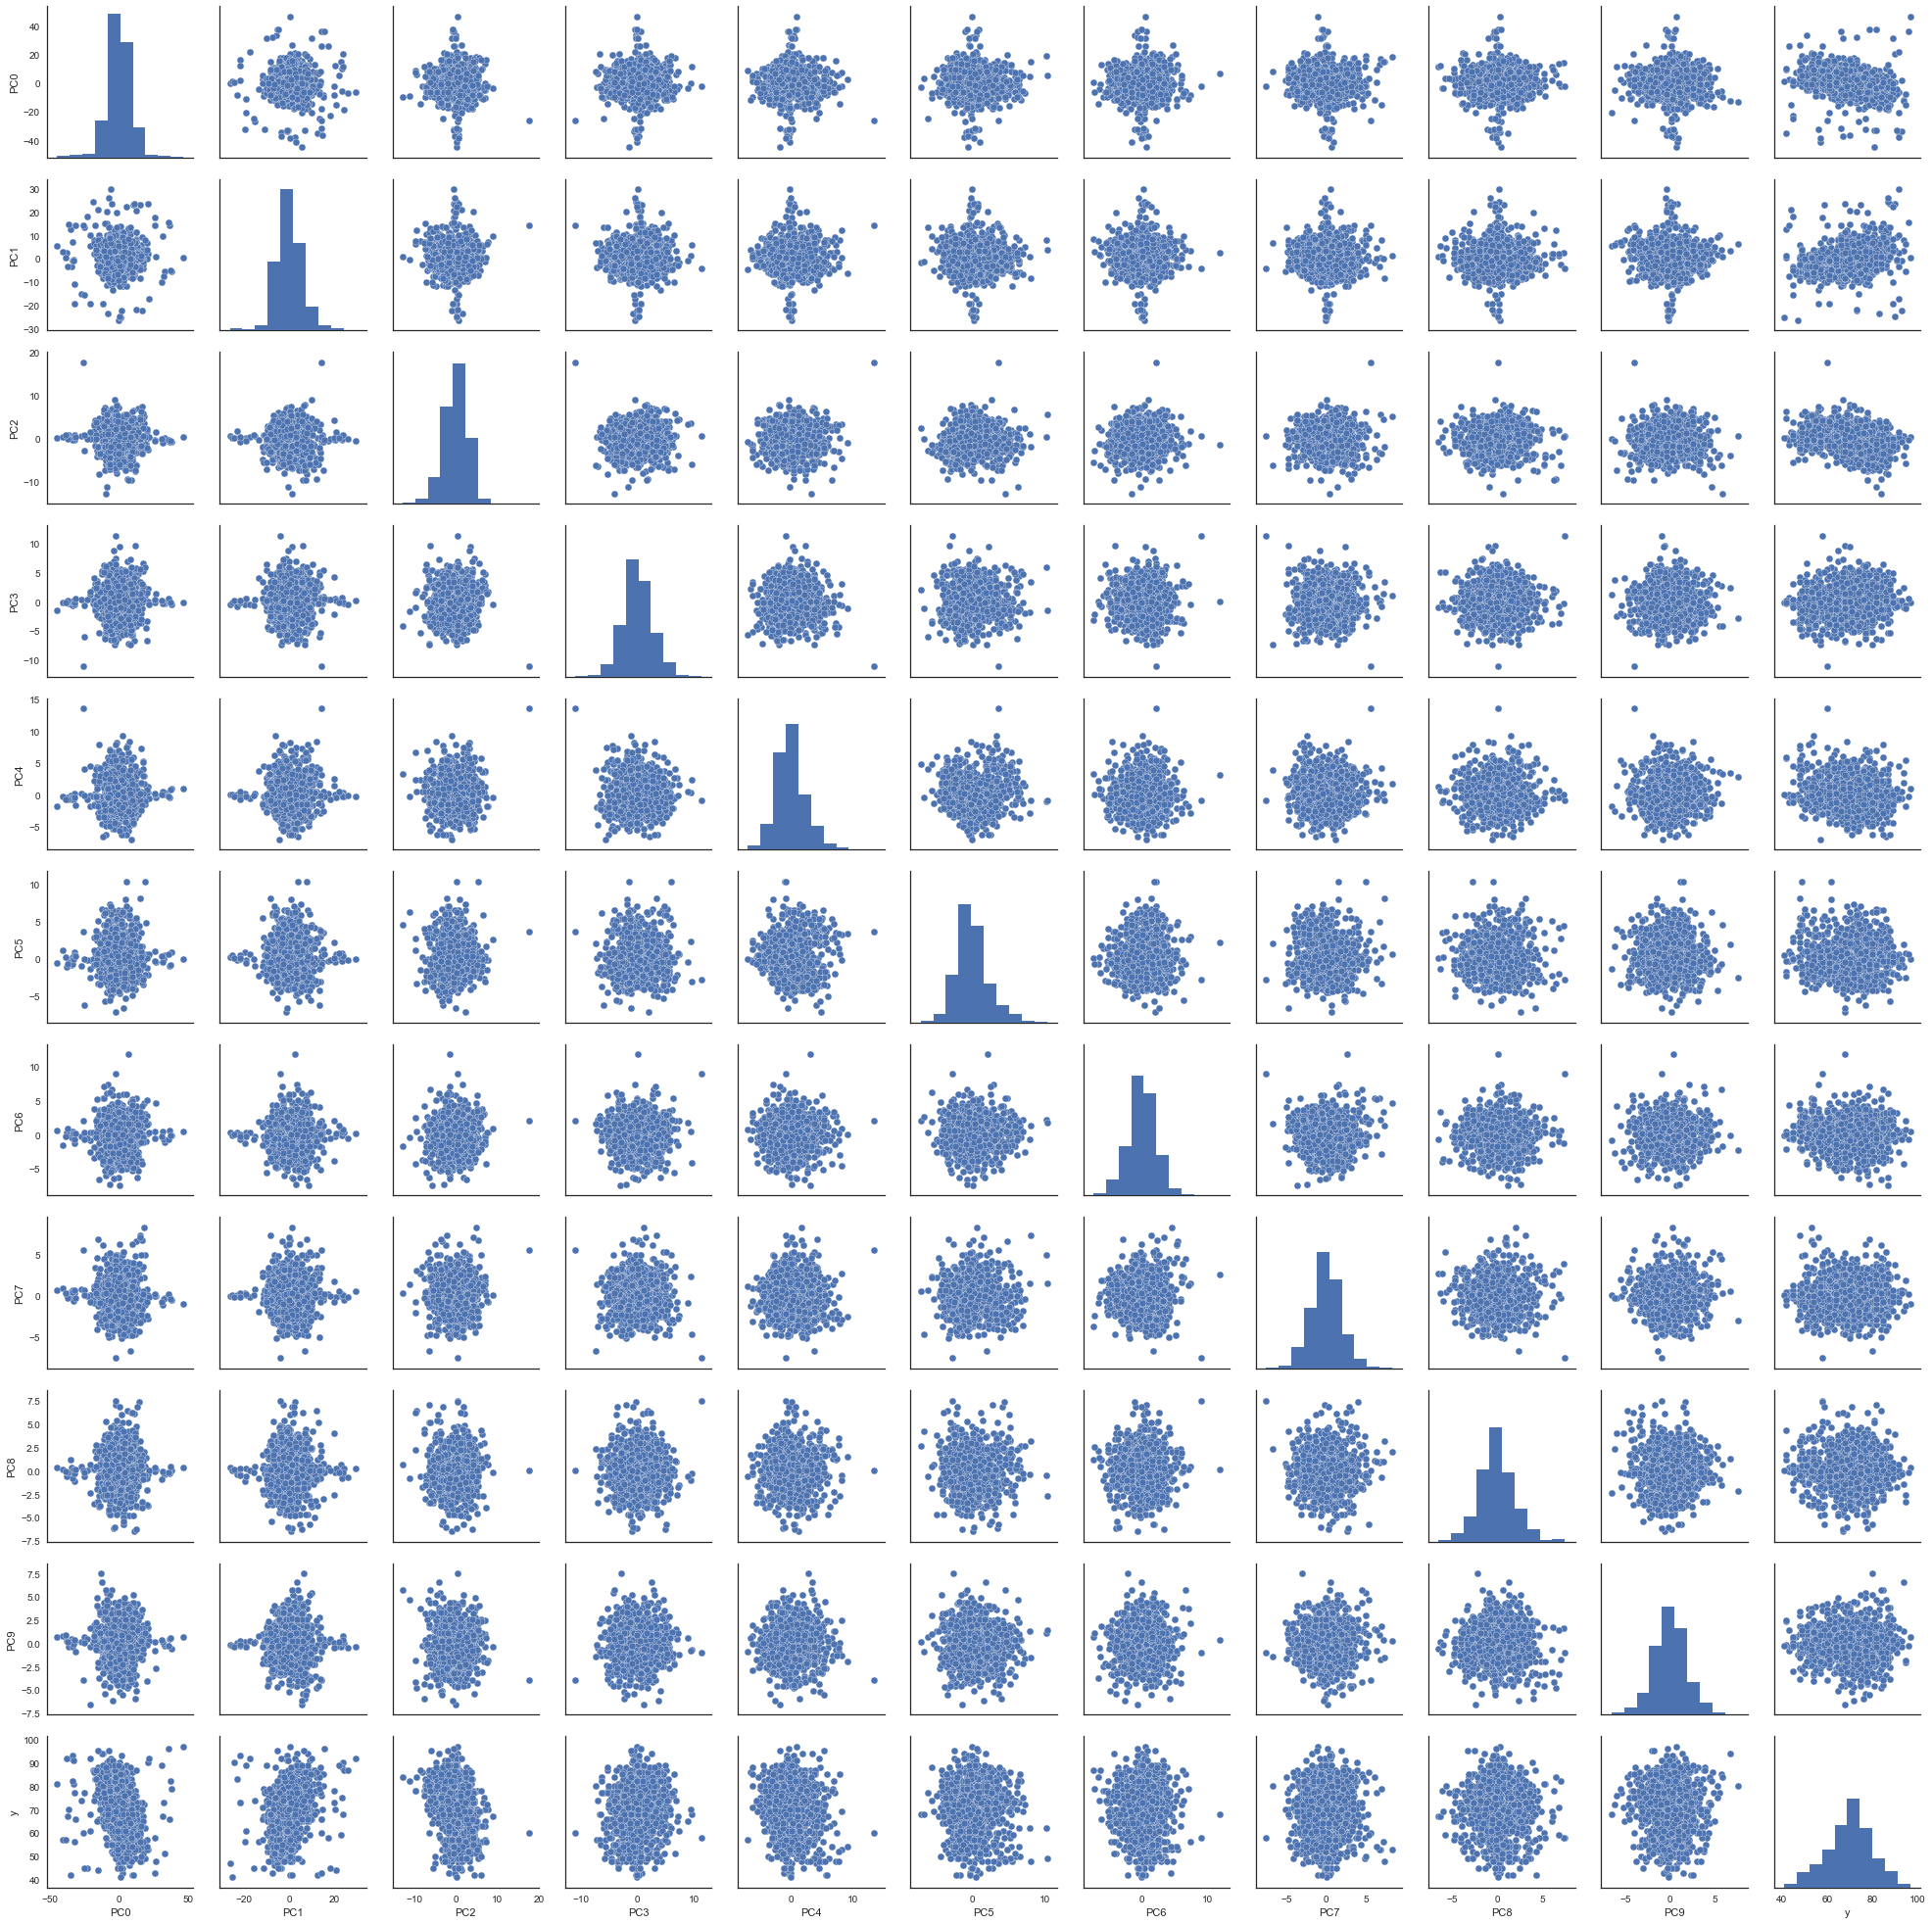

In [36]:
import seaborn as sns
sns.set(style="white")

sns.pairplot(xpca)


# Now try to select top K mutual info ones and plot it

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
n_comp = 30
X_new = SelectKBest(mutual_info_regression, k=n_comp).fit_transform(xtrain, ytrain)
xpca = pd.DataFrame(data = X_new, columns = ['PC' + str(i) for i in range(n_comp)])
xpca['y'] = ytrain

In [ ]:
import seaborn as sns
sns.set(style="white")

sns.pairplot(xpca)

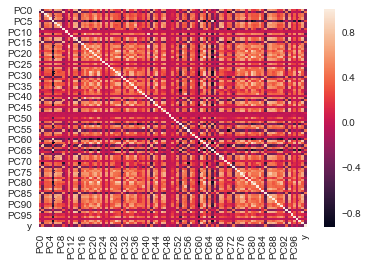

In [100]:
sns.heatmap(xpca.corr())

# Try XGBoost parameter optimization

In [6]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform, expon
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

k=10
modello = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)
scores = cross_val_score(estimator = modello,
                             X = xtrain,
                             y = ytrain,
                             scoring = 'r2',
                             cv = k)


print(np.mean(scores))
print(np.std(scores))

0.5175284544897842
0.06340326086136805


In [7]:
print(np.mean(scores))
print(np.std(scores))

0.5175284544897842
0.06340326086136805


In [8]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [9]:
# Remove outliers using Isolation Forest

# Fit an isolation forest
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=50)
clf.fit(xtrain)
clf.decision_function(xtrain)
inlier_indices = np.where(clf.predict(xtrain) == 1)[0]
print("Size of inliers:", inlier_indices.shape)

# Create a new xtrain, ytrain with only inlier points by indexing them at these indices
xtrain_inliers = xtrain.iloc[inlier_indices]
ytrain_inliers = ytrain.iloc[inlier_indices]
print(xtrain_inliers.shape)
print(ytrain_inliers.shape)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Size of inliers: (1090,)
(1090, 832)
(1090, 1)


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


# Random Search

In [21]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": sp_randint(2, 5),
              "learning_rate": expon(),
              "n_estimators": sp_randint(1, 200),
              "gamma": sp_randint(0, 2),
              "min_child_weight": sp_randint(0, 3),
              "max_delta_step": sp_randint(0, 3),
              "subsample": uniform(),
              "colsample_bytree": uniform(),
              "colsample_bylevel": uniform(), 
              "colsample_bynode": uniform(),
              "reg_alpha": expon(),
              "reg_lambda": expon(),
              "scale_pos_weight": expon()}

# run randomized search
n_iter_search = 40
random_search = RandomizedSearchCV(modello, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=10, iid=False, scoring='r2', verbose=2)

random_search.fit(xtrain_inliers, ytrain_inliers)
report(random_search.cv_results_)


Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] colsample_bylevel=0.6940204588191665, colsample_bynode=0.48461785364760634, colsample_bytree=0.19435105284834553, gamma=1, learning_rate=0.044854163366342535, max_delta_step=1, max_depth=2, min_child_weight=1, n_estimators=169, reg_alpha=1.358984713779223, reg_lambda=0.5898950808880591, scale_pos_weight=4.122289716900671, subsample=0.7160644728964032 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bylevel=0.6940204588191665, colsample_bynode=0.48461785364760634, colsample_bytree=0.19435105284834553, gamma=1, learning_rate=0.044854163366342535, max_delta_step=1, max_depth=2, min_child_weight=1, n_estimators=169, reg_alpha=1.358984713779223, reg_lambda=0.5898950808880591, scale_pos_weight=4.122289716900671, subsample=0.7160644728964032, total=   2.0s
[CV] colsample_bylevel=0.6940204588191665, colsample_bynode=0.48461785364760634, colsample_bytree=0.19435105284834553, gamma=1, learning_rate=0.044854163366342535, max_delta_step=1, max_depth=2, min_child_weight=1, n_estimators=169, reg_alpha=1.358984713779223, reg_lambda=0.5898950808880591, scale_pos_weight=4.122289716900671, subsample=0.7160644728964032 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  colsample_bylevel=0.6940204588191665, colsample_bynode=0.48461785364760634, colsample_bytree=0.19435105284834553, gamma=1, learning_rate=0.044854163366342535, max_delta_step=1, max_depth=2, min_child_weight=1, n_estimators=169, reg_alpha=1.358984713779223, reg_lambda=0.5898950808880591, scale_pos_weight=4.122289716900671, subsample=0.7160644728964032, total=   2.8s
[CV] colsample_bylevel=0.6940204588191665, colsample_bynode=0.48461785364760634, colsample_bytree=0.19435105284834553, gamma=1, learning_rate=0.044854163366342535, max_delta_step=1, max_depth=2, min_child_weight=1, n_estimators=169, reg_alpha=1.358984713779223, reg_lambda=0.5898950808880591, scale_pos_weight=4.122289716900671, subsample=0.7160644728964032 
[CV]  colsample_bylevel=0.6940204588191665, colsample_bynode=0.48461785364760634, colsample_bytree=0.19435105284834553, gamma=1, learning_rate=0.044854163366342535, max_delta_step=1, max_depth=2, min_child_weight=1, n_estimators=169, reg_alpha=1.358984713779223, reg_

[CV]  colsample_bylevel=0.36495221198560024, colsample_bynode=0.2938376914176877, colsample_bytree=0.0622704820390122, gamma=0, learning_rate=0.6529374366827161, max_delta_step=1, max_depth=2, min_child_weight=1, n_estimators=103, reg_alpha=1.0609142497899664, reg_lambda=1.514041185165322, scale_pos_weight=0.6226750274850157, subsample=0.34758838672002, total=   1.2s
[CV] colsample_bylevel=0.36495221198560024, colsample_bynode=0.2938376914176877, colsample_bytree=0.0622704820390122, gamma=0, learning_rate=0.6529374366827161, max_delta_step=1, max_depth=2, min_child_weight=1, n_estimators=103, reg_alpha=1.0609142497899664, reg_lambda=1.514041185165322, scale_pos_weight=0.6226750274850157, subsample=0.34758838672002 
[CV]  colsample_bylevel=0.36495221198560024, colsample_bynode=0.2938376914176877, colsample_bytree=0.0622704820390122, gamma=0, learning_rate=0.6529374366827161, max_delta_step=1, max_depth=2, min_child_weight=1, n_estimators=103, reg_alpha=1.0609142497899664, reg_lambda=1.5

[CV]  colsample_bylevel=0.3634617592869923, colsample_bynode=0.11826688487492298, colsample_bytree=0.6605834437510074, gamma=0, learning_rate=0.3096320856111484, max_delta_step=2, max_depth=3, min_child_weight=1, n_estimators=24, reg_alpha=2.447683284428914, reg_lambda=3.2894670419030647, scale_pos_weight=4.438840597697206, subsample=0.6696915734340366, total=   0.3s
[CV] colsample_bylevel=0.3634617592869923, colsample_bynode=0.11826688487492298, colsample_bytree=0.6605834437510074, gamma=0, learning_rate=0.3096320856111484, max_delta_step=2, max_depth=3, min_child_weight=1, n_estimators=24, reg_alpha=2.447683284428914, reg_lambda=3.2894670419030647, scale_pos_weight=4.438840597697206, subsample=0.6696915734340366 
[CV]  colsample_bylevel=0.3634617592869923, colsample_bynode=0.11826688487492298, colsample_bytree=0.6605834437510074, gamma=0, learning_rate=0.3096320856111484, max_delta_step=2, max_depth=3, min_child_weight=1, n_estimators=24, reg_alpha=2.447683284428914, reg_lambda=3.289

[CV]  colsample_bylevel=0.7248748575271301, colsample_bynode=0.012017854552153762, colsample_bytree=0.39273110061513694, gamma=0, learning_rate=0.545010686177321, max_delta_step=0, max_depth=2, min_child_weight=0, n_estimators=118, reg_alpha=1.8774271412162264, reg_lambda=0.04643917757032498, scale_pos_weight=4.264491342660903, subsample=0.7834459295539117, total=   1.3s
[CV] colsample_bylevel=0.7248748575271301, colsample_bynode=0.012017854552153762, colsample_bytree=0.39273110061513694, gamma=0, learning_rate=0.545010686177321, max_delta_step=0, max_depth=2, min_child_weight=0, n_estimators=118, reg_alpha=1.8774271412162264, reg_lambda=0.04643917757032498, scale_pos_weight=4.264491342660903, subsample=0.7834459295539117 
[CV]  colsample_bylevel=0.7248748575271301, colsample_bynode=0.012017854552153762, colsample_bytree=0.39273110061513694, gamma=0, learning_rate=0.545010686177321, max_delta_step=0, max_depth=2, min_child_weight=0, n_estimators=118, reg_alpha=1.8774271412162264, reg_l

[CV]  colsample_bylevel=0.8788080440633088, colsample_bynode=0.019440516041661637, colsample_bytree=0.7875673665095329, gamma=0, learning_rate=0.5680561119870382, max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=151, reg_alpha=2.336420814795828, reg_lambda=4.15604601037838, scale_pos_weight=0.36000458508275657, subsample=0.9593649150524055, total=   1.8s
[CV] colsample_bylevel=0.06267205785039309, colsample_bynode=0.594745194362174, colsample_bytree=0.7832251337206494, gamma=0, learning_rate=0.22710706721027232, max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=11, reg_alpha=0.6203042829957066, reg_lambda=0.22548149366379344, scale_pos_weight=0.2476401379040409, subsample=0.4287643557061087 
[CV]  colsample_bylevel=0.06267205785039309, colsample_bynode=0.594745194362174, colsample_bytree=0.7832251337206494, gamma=0, learning_rate=0.22710706721027232, max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=11, reg_alpha=0.6203042829957066, reg_lambda

[CV]  colsample_bylevel=0.4350085411662161, colsample_bynode=0.9090460675414964, colsample_bytree=0.22598525218716192, gamma=0, learning_rate=0.7481144795041901, max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=157, reg_alpha=0.7768047078460374, reg_lambda=1.8023880818523652, scale_pos_weight=1.5019163861291334, subsample=0.7086495037645324, total=   2.3s
[CV] colsample_bylevel=0.4350085411662161, colsample_bynode=0.9090460675414964, colsample_bytree=0.22598525218716192, gamma=0, learning_rate=0.7481144795041901, max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=157, reg_alpha=0.7768047078460374, reg_lambda=1.8023880818523652, scale_pos_weight=1.5019163861291334, subsample=0.7086495037645324 
[CV]  colsample_bylevel=0.4350085411662161, colsample_bynode=0.9090460675414964, colsample_bytree=0.22598525218716192, gamma=0, learning_rate=0.7481144795041901, max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=157, reg_alpha=0.7768047078460374, reg_lamb

[CV]  colsample_bylevel=0.33576330544115873, colsample_bynode=0.19658104607827576, colsample_bytree=0.7303287692493248, gamma=0, learning_rate=0.46269885722150583, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=82, reg_alpha=0.5529773198861051, reg_lambda=1.1278955085291416, scale_pos_weight=1.3255780787834779, subsample=0.9910864636215918, total=   1.0s
[CV] colsample_bylevel=0.33576330544115873, colsample_bynode=0.19658104607827576, colsample_bytree=0.7303287692493248, gamma=0, learning_rate=0.46269885722150583, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=82, reg_alpha=0.5529773198861051, reg_lambda=1.1278955085291416, scale_pos_weight=1.3255780787834779, subsample=0.9910864636215918 
[CV]  colsample_bylevel=0.33576330544115873, colsample_bynode=0.19658104607827576, colsample_bytree=0.7303287692493248, gamma=0, learning_rate=0.46269885722150583, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=82, reg_alpha=0.5529773198861051, reg_l

[CV]  colsample_bylevel=0.8390695869492705, colsample_bynode=0.686535864417756, colsample_bytree=0.7644757145469093, gamma=1, learning_rate=0.6682633725475454, max_delta_step=2, max_depth=4, min_child_weight=2, n_estimators=82, reg_alpha=0.8399353311334973, reg_lambda=1.1687865853843418, scale_pos_weight=1.7072173398229291, subsample=0.06978786208477228, total=   1.3s
[CV] colsample_bylevel=0.8390695869492705, colsample_bynode=0.686535864417756, colsample_bytree=0.7644757145469093, gamma=1, learning_rate=0.6682633725475454, max_delta_step=2, max_depth=4, min_child_weight=2, n_estimators=82, reg_alpha=0.8399353311334973, reg_lambda=1.1687865853843418, scale_pos_weight=1.7072173398229291, subsample=0.06978786208477228 
[CV]  colsample_bylevel=0.8390695869492705, colsample_bynode=0.686535864417756, colsample_bytree=0.7644757145469093, gamma=1, learning_rate=0.6682633725475454, max_delta_step=2, max_depth=4, min_child_weight=2, n_estimators=82, reg_alpha=0.8399353311334973, reg_lambda=1.16

[CV]  colsample_bylevel=0.36956732452773444, colsample_bynode=0.8225997545248716, colsample_bytree=0.44454891752908354, gamma=0, learning_rate=0.5130877457025942, max_delta_step=2, max_depth=4, min_child_weight=2, n_estimators=110, reg_alpha=1.1635371399369367, reg_lambda=1.784039113271072, scale_pos_weight=5.840654221136759, subsample=0.08262638566755165, total=   1.4s
[CV] colsample_bylevel=0.36956732452773444, colsample_bynode=0.8225997545248716, colsample_bytree=0.44454891752908354, gamma=0, learning_rate=0.5130877457025942, max_delta_step=2, max_depth=4, min_child_weight=2, n_estimators=110, reg_alpha=1.1635371399369367, reg_lambda=1.784039113271072, scale_pos_weight=5.840654221136759, subsample=0.08262638566755165 
[CV]  colsample_bylevel=0.36956732452773444, colsample_bynode=0.8225997545248716, colsample_bytree=0.44454891752908354, gamma=0, learning_rate=0.5130877457025942, max_delta_step=2, max_depth=4, min_child_weight=2, n_estimators=110, reg_alpha=1.1635371399369367, reg_lam

[CV]  colsample_bylevel=0.684145166394798, colsample_bynode=0.4513590054143467, colsample_bytree=0.8787226490243815, gamma=1, learning_rate=0.685583178756702, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=136, reg_alpha=0.5927384531157498, reg_lambda=0.14190292568829732, scale_pos_weight=1.893714219030218, subsample=0.6288417390771154, total=   3.0s
[CV] colsample_bylevel=0.4463854685724973, colsample_bynode=0.7983944009689389, colsample_bytree=0.4930404183797631, gamma=1, learning_rate=0.20410854407045195, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=35, reg_alpha=0.4660136271091478, reg_lambda=0.8665576304250372, scale_pos_weight=2.3081277414081294, subsample=0.18892172013106023 
[CV]  colsample_bylevel=0.4463854685724973, colsample_bynode=0.7983944009689389, colsample_bytree=0.4930404183797631, gamma=1, learning_rate=0.20410854407045195, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=35, reg_alpha=0.4660136271091478, reg_lambda=0

[CV]  colsample_bylevel=0.16256384317488948, colsample_bynode=0.6787466245801616, colsample_bytree=0.4037055596562774, gamma=0, learning_rate=0.740537937387095, max_delta_step=2, max_depth=2, min_child_weight=0, n_estimators=126, reg_alpha=1.9025304101379998, reg_lambda=0.36264317512764205, scale_pos_weight=0.3936480562108978, subsample=0.352837690536406, total=   1.6s
[CV] colsample_bylevel=0.16256384317488948, colsample_bynode=0.6787466245801616, colsample_bytree=0.4037055596562774, gamma=0, learning_rate=0.740537937387095, max_delta_step=2, max_depth=2, min_child_weight=0, n_estimators=126, reg_alpha=1.9025304101379998, reg_lambda=0.36264317512764205, scale_pos_weight=0.3936480562108978, subsample=0.352837690536406 
[CV]  colsample_bylevel=0.16256384317488948, colsample_bynode=0.6787466245801616, colsample_bytree=0.4037055596562774, gamma=0, learning_rate=0.740537937387095, max_delta_step=2, max_depth=2, min_child_weight=0, n_estimators=126, reg_alpha=1.9025304101379998, reg_lambda=

[CV]  colsample_bylevel=0.40593558335516045, colsample_bynode=0.34816112558718626, colsample_bytree=0.7190433356493166, gamma=0, learning_rate=1.3689655095329165, max_delta_step=0, max_depth=2, min_child_weight=1, n_estimators=177, reg_alpha=1.9958884031485702, reg_lambda=0.30988532406757835, scale_pos_weight=0.07564791990384778, subsample=0.2810828539079062, total=   2.3s
[CV] colsample_bylevel=0.40593558335516045, colsample_bynode=0.34816112558718626, colsample_bytree=0.7190433356493166, gamma=0, learning_rate=1.3689655095329165, max_delta_step=0, max_depth=2, min_child_weight=1, n_estimators=177, reg_alpha=1.9958884031485702, reg_lambda=0.30988532406757835, scale_pos_weight=0.07564791990384778, subsample=0.2810828539079062 
[CV]  colsample_bylevel=0.40593558335516045, colsample_bynode=0.34816112558718626, colsample_bytree=0.7190433356493166, gamma=0, learning_rate=1.3689655095329165, max_delta_step=0, max_depth=2, min_child_weight=1, n_estimators=177, reg_alpha=1.9958884031485702, r

[CV]  colsample_bylevel=0.14912895648152757, colsample_bynode=0.3994169563793376, colsample_bytree=0.6014120997942501, gamma=0, learning_rate=2.284939984868675, max_delta_step=1, max_depth=3, min_child_weight=2, n_estimators=168, reg_alpha=0.1357319652490993, reg_lambda=0.11632657178641682, scale_pos_weight=0.9843045470852334, subsample=0.4276400135560302, total=   2.3s
[CV] colsample_bylevel=0.14912895648152757, colsample_bynode=0.3994169563793376, colsample_bytree=0.6014120997942501, gamma=0, learning_rate=2.284939984868675, max_delta_step=1, max_depth=3, min_child_weight=2, n_estimators=168, reg_alpha=0.1357319652490993, reg_lambda=0.11632657178641682, scale_pos_weight=0.9843045470852334, subsample=0.4276400135560302 
[CV]  colsample_bylevel=0.14912895648152757, colsample_bynode=0.3994169563793376, colsample_bytree=0.6014120997942501, gamma=0, learning_rate=2.284939984868675, max_delta_step=1, max_depth=3, min_child_weight=2, n_estimators=168, reg_alpha=0.1357319652490993, reg_lambd

[CV]  colsample_bylevel=0.5365091791412945, colsample_bynode=0.20164153858702227, colsample_bytree=0.7465630363772735, gamma=1, learning_rate=0.40998120054145704, max_delta_step=2, max_depth=4, min_child_weight=0, n_estimators=89, reg_alpha=0.0002642680862782999, reg_lambda=0.6371867448568809, scale_pos_weight=0.3054520772907702, subsample=0.3471866559662937, total=   1.1s
[CV] colsample_bylevel=0.5365091791412945, colsample_bynode=0.20164153858702227, colsample_bytree=0.7465630363772735, gamma=1, learning_rate=0.40998120054145704, max_delta_step=2, max_depth=4, min_child_weight=0, n_estimators=89, reg_alpha=0.0002642680862782999, reg_lambda=0.6371867448568809, scale_pos_weight=0.3054520772907702, subsample=0.3471866559662937 
[CV]  colsample_bylevel=0.5365091791412945, colsample_bynode=0.20164153858702227, colsample_bytree=0.7465630363772735, gamma=1, learning_rate=0.40998120054145704, max_delta_step=2, max_depth=4, min_child_weight=0, n_estimators=89, reg_alpha=0.0002642680862782999,

[CV]  colsample_bylevel=0.05370762033793752, colsample_bynode=0.13190111146130878, colsample_bytree=0.0954773982351661, gamma=1, learning_rate=0.48633640958339913, max_delta_step=1, max_depth=4, min_child_weight=0, n_estimators=181, reg_alpha=0.42634905678112267, reg_lambda=0.3618197876631448, scale_pos_weight=0.04579081617255816, subsample=0.1016389278461709, total=   2.3s
[CV] colsample_bylevel=0.06775116648069346, colsample_bynode=0.8557535640524088, colsample_bytree=0.6518462387387456, gamma=0, learning_rate=0.15341460019747816, max_delta_step=1, max_depth=4, min_child_weight=1, n_estimators=156, reg_alpha=0.517522868468153, reg_lambda=0.11536463000957974, scale_pos_weight=2.071535484321611, subsample=0.06032521105786437 
[CV]  colsample_bylevel=0.06775116648069346, colsample_bynode=0.8557535640524088, colsample_bytree=0.6518462387387456, gamma=0, learning_rate=0.15341460019747816, max_delta_step=1, max_depth=4, min_child_weight=1, n_estimators=156, reg_alpha=0.517522868468153, reg

[CV]  colsample_bylevel=0.6827194513464497, colsample_bynode=0.19208591365762606, colsample_bytree=0.49140865258060384, gamma=1, learning_rate=2.6677743558554607, max_delta_step=1, max_depth=2, min_child_weight=2, n_estimators=188, reg_alpha=0.7050520385171146, reg_lambda=0.7806791486493277, scale_pos_weight=0.38940607444798947, subsample=0.3907773449613263, total=   2.2s
[CV] colsample_bylevel=0.6827194513464497, colsample_bynode=0.19208591365762606, colsample_bytree=0.49140865258060384, gamma=1, learning_rate=2.6677743558554607, max_delta_step=1, max_depth=2, min_child_weight=2, n_estimators=188, reg_alpha=0.7050520385171146, reg_lambda=0.7806791486493277, scale_pos_weight=0.38940607444798947, subsample=0.3907773449613263 
[CV]  colsample_bylevel=0.6827194513464497, colsample_bynode=0.19208591365762606, colsample_bytree=0.49140865258060384, gamma=1, learning_rate=2.6677743558554607, max_delta_step=1, max_depth=2, min_child_weight=2, n_estimators=188, reg_alpha=0.7050520385171146, reg

[CV]  colsample_bylevel=0.09058320819330756, colsample_bynode=0.46978821314946473, colsample_bytree=0.6784856021475124, gamma=0, learning_rate=3.9062377217713697, max_delta_step=2, max_depth=3, min_child_weight=2, n_estimators=183, reg_alpha=0.425936173320217, reg_lambda=0.3901564944765025, scale_pos_weight=1.8556384260166476, subsample=0.7160503142049106, total=   2.7s
[CV] colsample_bylevel=0.09058320819330756, colsample_bynode=0.46978821314946473, colsample_bytree=0.6784856021475124, gamma=0, learning_rate=3.9062377217713697, max_delta_step=2, max_depth=3, min_child_weight=2, n_estimators=183, reg_alpha=0.425936173320217, reg_lambda=0.3901564944765025, scale_pos_weight=1.8556384260166476, subsample=0.7160503142049106 
[CV]  colsample_bylevel=0.09058320819330756, colsample_bynode=0.46978821314946473, colsample_bytree=0.6784856021475124, gamma=0, learning_rate=3.9062377217713697, max_delta_step=2, max_depth=3, min_child_weight=2, n_estimators=183, reg_alpha=0.425936173320217, reg_lamb

[CV]  colsample_bylevel=0.8735914025623607, colsample_bynode=0.2944728092365767, colsample_bytree=0.07277854821923069, gamma=1, learning_rate=0.007255239852119773, max_delta_step=0, max_depth=4, min_child_weight=2, n_estimators=21, reg_alpha=0.11811136472931484, reg_lambda=0.24632788973911973, scale_pos_weight=2.548462266723829, subsample=0.6594776877873569, total=   0.3s
[CV] colsample_bylevel=0.8735914025623607, colsample_bynode=0.2944728092365767, colsample_bytree=0.07277854821923069, gamma=1, learning_rate=0.007255239852119773, max_delta_step=0, max_depth=4, min_child_weight=2, n_estimators=21, reg_alpha=0.11811136472931484, reg_lambda=0.24632788973911973, scale_pos_weight=2.548462266723829, subsample=0.6594776877873569 
[CV]  colsample_bylevel=0.8735914025623607, colsample_bynode=0.2944728092365767, colsample_bytree=0.07277854821923069, gamma=1, learning_rate=0.007255239852119773, max_delta_step=0, max_depth=4, min_child_weight=2, n_estimators=21, reg_alpha=0.11811136472931484, re

[CV]  colsample_bylevel=0.15502045140250265, colsample_bynode=0.44833046496594076, colsample_bytree=0.43115082288542106, gamma=1, learning_rate=0.10423304963015964, max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=33, reg_alpha=2.140566549070904, reg_lambda=0.548180510834918, scale_pos_weight=1.22806449623478, subsample=0.9429465700612252, total=   0.4s
[CV] colsample_bylevel=0.15502045140250265, colsample_bynode=0.44833046496594076, colsample_bytree=0.43115082288542106, gamma=1, learning_rate=0.10423304963015964, max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=33, reg_alpha=2.140566549070904, reg_lambda=0.548180510834918, scale_pos_weight=1.22806449623478, subsample=0.9429465700612252 
[CV]  colsample_bylevel=0.15502045140250265, colsample_bynode=0.44833046496594076, colsample_bytree=0.43115082288542106, gamma=1, learning_rate=0.10423304963015964, max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=33, reg_alpha=2.140566549070904, reg_lambda=

[CV]  colsample_bylevel=0.37060829685573926, colsample_bynode=0.026788205704794343, colsample_bytree=0.04003457088789586, gamma=0, learning_rate=0.5067697830108964, max_delta_step=1, max_depth=2, min_child_weight=1, n_estimators=150, reg_alpha=0.08634475571382913, reg_lambda=1.7878310660982781, scale_pos_weight=0.3759790384202963, subsample=0.41847361293510144, total=   1.6s
[CV] colsample_bylevel=0.12114891972501185, colsample_bynode=0.5596026751114168, colsample_bytree=0.49366894415111373, gamma=1, learning_rate=0.08554753185694967, max_delta_step=2, max_depth=2, min_child_weight=0, n_estimators=150, reg_alpha=3.8178901895887556, reg_lambda=1.70122124092409, scale_pos_weight=3.425330306223013, subsample=0.6224720436507757 
[CV]  colsample_bylevel=0.12114891972501185, colsample_bynode=0.5596026751114168, colsample_bytree=0.49366894415111373, gamma=1, learning_rate=0.08554753185694967, max_delta_step=2, max_depth=2, min_child_weight=0, n_estimators=150, reg_alpha=3.8178901895887556, re

[CV]  colsample_bylevel=0.7994993430484196, colsample_bynode=0.6889283666985185, colsample_bytree=0.27860174494494383, gamma=0, learning_rate=0.0403899582736214, max_delta_step=2, max_depth=4, min_child_weight=1, n_estimators=25, reg_alpha=0.36748513331458754, reg_lambda=0.14386578048083873, scale_pos_weight=0.915317078952315, subsample=0.6691225737720161, total=   0.4s
[CV] colsample_bylevel=0.7994993430484196, colsample_bynode=0.6889283666985185, colsample_bytree=0.27860174494494383, gamma=0, learning_rate=0.0403899582736214, max_delta_step=2, max_depth=4, min_child_weight=1, n_estimators=25, reg_alpha=0.36748513331458754, reg_lambda=0.14386578048083873, scale_pos_weight=0.915317078952315, subsample=0.6691225737720161 
[CV]  colsample_bylevel=0.7994993430484196, colsample_bynode=0.6889283666985185, colsample_bytree=0.27860174494494383, gamma=0, learning_rate=0.0403899582736214, max_delta_step=2, max_depth=4, min_child_weight=1, n_estimators=25, reg_alpha=0.36748513331458754, reg_lamb

[CV]  colsample_bylevel=0.9876956053988414, colsample_bynode=0.6495540512841829, colsample_bytree=0.6862286356039825, gamma=0, learning_rate=0.9305655948991306, max_delta_step=2, max_depth=4, min_child_weight=0, n_estimators=26, reg_alpha=0.9350965148153891, reg_lambda=0.04655486654745549, scale_pos_weight=0.012486061357132545, subsample=0.08090488329054057, total=   0.4s
[CV] colsample_bylevel=0.9876956053988414, colsample_bynode=0.6495540512841829, colsample_bytree=0.6862286356039825, gamma=0, learning_rate=0.9305655948991306, max_delta_step=2, max_depth=4, min_child_weight=0, n_estimators=26, reg_alpha=0.9350965148153891, reg_lambda=0.04655486654745549, scale_pos_weight=0.012486061357132545, subsample=0.08090488329054057 
[CV]  colsample_bylevel=0.9876956053988414, colsample_bynode=0.6495540512841829, colsample_bytree=0.6862286356039825, gamma=0, learning_rate=0.9305655948991306, max_delta_step=2, max_depth=4, min_child_weight=0, n_estimators=26, reg_alpha=0.9350965148153891, reg_la

[CV]  colsample_bylevel=0.791626263931058, colsample_bynode=0.06712223203558954, colsample_bytree=0.9904222010620715, gamma=1, learning_rate=1.4418129502578365, max_delta_step=1, max_depth=2, min_child_weight=2, n_estimators=147, reg_alpha=0.06391526794676665, reg_lambda=2.3305327624288594, scale_pos_weight=0.2992274306817255, subsample=0.03576783828853258, total=   1.9s
[CV] colsample_bylevel=0.791626263931058, colsample_bynode=0.06712223203558954, colsample_bytree=0.9904222010620715, gamma=1, learning_rate=1.4418129502578365, max_delta_step=1, max_depth=2, min_child_weight=2, n_estimators=147, reg_alpha=0.06391526794676665, reg_lambda=2.3305327624288594, scale_pos_weight=0.2992274306817255, subsample=0.03576783828853258 
[CV]  colsample_bylevel=0.791626263931058, colsample_bynode=0.06712223203558954, colsample_bytree=0.9904222010620715, gamma=1, learning_rate=1.4418129502578365, max_delta_step=1, max_depth=2, min_child_weight=2, n_estimators=147, reg_alpha=0.06391526794676665, reg_la

[CV]  colsample_bylevel=0.26933018226812244, colsample_bynode=0.756572785918546, colsample_bytree=0.9505964195638305, gamma=0, learning_rate=0.5006605430607621, max_delta_step=1, max_depth=2, min_child_weight=0, n_estimators=117, reg_alpha=1.3086625505872058, reg_lambda=1.0767776974148784, scale_pos_weight=0.9776866542322878, subsample=0.7766986689992441, total=   1.7s
[CV] colsample_bylevel=0.26933018226812244, colsample_bynode=0.756572785918546, colsample_bytree=0.9505964195638305, gamma=0, learning_rate=0.5006605430607621, max_delta_step=1, max_depth=2, min_child_weight=0, n_estimators=117, reg_alpha=1.3086625505872058, reg_lambda=1.0767776974148784, scale_pos_weight=0.9776866542322878, subsample=0.7766986689992441 
[CV]  colsample_bylevel=0.26933018226812244, colsample_bynode=0.756572785918546, colsample_bytree=0.9505964195638305, gamma=0, learning_rate=0.5006605430607621, max_delta_step=1, max_depth=2, min_child_weight=0, n_estimators=117, reg_alpha=1.3086625505872058, reg_lambda=

[CV]  colsample_bylevel=0.6626984459424655, colsample_bynode=0.16202288714930557, colsample_bytree=0.7201947666400775, gamma=0, learning_rate=0.4275120735061565, max_delta_step=2, max_depth=4, min_child_weight=1, n_estimators=49, reg_alpha=0.7387287931432875, reg_lambda=0.047894281170909714, scale_pos_weight=1.9543135704592371, subsample=0.3079035297708189, total=   0.6s
[CV] colsample_bylevel=0.33711152731119887, colsample_bynode=0.6270820992632954, colsample_bytree=0.4105024521789645, gamma=1, learning_rate=2.795759297061576, max_delta_step=1, max_depth=4, min_child_weight=0, n_estimators=8, reg_alpha=0.2583942938646708, reg_lambda=0.05959384221039774, scale_pos_weight=0.19204161888892846, subsample=0.787489028870385 
[CV]  colsample_bylevel=0.33711152731119887, colsample_bynode=0.6270820992632954, colsample_bytree=0.4105024521789645, gamma=1, learning_rate=2.795759297061576, max_delta_step=1, max_depth=4, min_child_weight=0, n_estimators=8, reg_alpha=0.2583942938646708, reg_lambda=0

[CV]  colsample_bylevel=0.11727406227147663, colsample_bynode=0.3287704034630484, colsample_bytree=0.38270115675262595, gamma=1, learning_rate=0.7051434289757239, max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=57, reg_alpha=0.6725832648212287, reg_lambda=0.2157136379182469, scale_pos_weight=1.0874185690172284, subsample=0.44060503484635505, total=   0.7s
[CV] colsample_bylevel=0.11727406227147663, colsample_bynode=0.3287704034630484, colsample_bytree=0.38270115675262595, gamma=1, learning_rate=0.7051434289757239, max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=57, reg_alpha=0.6725832648212287, reg_lambda=0.2157136379182469, scale_pos_weight=1.0874185690172284, subsample=0.44060503484635505 
[CV]  colsample_bylevel=0.11727406227147663, colsample_bynode=0.3287704034630484, colsample_bytree=0.38270115675262595, gamma=1, learning_rate=0.7051434289757239, max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=57, reg_alpha=0.6725832648212287, reg_la

[CV]  colsample_bylevel=0.44285345785414854, colsample_bynode=0.38782960768701213, colsample_bytree=0.9490934332643424, gamma=1, learning_rate=1.9428214731863536, max_delta_step=1, max_depth=4, min_child_weight=1, n_estimators=88, reg_alpha=0.030676793371099315, reg_lambda=2.6099866705781714, scale_pos_weight=0.42463001399693834, subsample=0.433256505940088, total=   1.6s
[CV] colsample_bylevel=0.44285345785414854, colsample_bynode=0.38782960768701213, colsample_bytree=0.9490934332643424, gamma=1, learning_rate=1.9428214731863536, max_delta_step=1, max_depth=4, min_child_weight=1, n_estimators=88, reg_alpha=0.030676793371099315, reg_lambda=2.6099866705781714, scale_pos_weight=0.42463001399693834, subsample=0.433256505940088 
[CV]  colsample_bylevel=0.44285345785414854, colsample_bynode=0.38782960768701213, colsample_bytree=0.9490934332643424, gamma=1, learning_rate=1.9428214731863536, max_delta_step=1, max_depth=4, min_child_weight=1, n_estimators=88, reg_alpha=0.030676793371099315, re

[CV]  colsample_bylevel=0.47933721165905374, colsample_bynode=0.2207166464408179, colsample_bytree=0.9681312270017182, gamma=0, learning_rate=1.8626084796184363, max_delta_step=2, max_depth=2, min_child_weight=0, n_estimators=130, reg_alpha=1.4894739386635847, reg_lambda=0.16547093679696598, scale_pos_weight=0.4422976754254437, subsample=0.6295726125547594, total=   1.8s
[CV] colsample_bylevel=0.47933721165905374, colsample_bynode=0.2207166464408179, colsample_bytree=0.9681312270017182, gamma=0, learning_rate=1.8626084796184363, max_delta_step=2, max_depth=2, min_child_weight=0, n_estimators=130, reg_alpha=1.4894739386635847, reg_lambda=0.16547093679696598, scale_pos_weight=0.4422976754254437, subsample=0.6295726125547594 
[CV]  colsample_bylevel=0.47933721165905374, colsample_bynode=0.2207166464408179, colsample_bytree=0.9681312270017182, gamma=0, learning_rate=1.8626084796184363, max_delta_step=2, max_depth=2, min_child_weight=0, n_estimators=130, reg_alpha=1.4894739386635847, reg_la

[CV]  colsample_bylevel=0.7825668342926325, colsample_bynode=0.726763820702772, colsample_bytree=0.7886551483381687, gamma=1, learning_rate=0.0020722334539383055, max_delta_step=0, max_depth=3, min_child_weight=0, n_estimators=190, reg_alpha=1.1188227178176742, reg_lambda=0.29294060636322933, scale_pos_weight=1.6548874229190917, subsample=0.870635750924306, total=   5.3s
[CV] colsample_bylevel=0.7825668342926325, colsample_bynode=0.726763820702772, colsample_bytree=0.7886551483381687, gamma=1, learning_rate=0.0020722334539383055, max_delta_step=0, max_depth=3, min_child_weight=0, n_estimators=190, reg_alpha=1.1188227178176742, reg_lambda=0.29294060636322933, scale_pos_weight=1.6548874229190917, subsample=0.870635750924306 
[CV]  colsample_bylevel=0.7825668342926325, colsample_bynode=0.726763820702772, colsample_bytree=0.7886551483381687, gamma=1, learning_rate=0.0020722334539383055, max_delta_step=0, max_depth=3, min_child_weight=0, n_estimators=190, reg_alpha=1.1188227178176742, reg_l

[CV]  colsample_bylevel=0.7613916154341921, colsample_bynode=0.4764620169009066, colsample_bytree=0.27386501977798283, gamma=1, learning_rate=2.5440722584754054, max_delta_step=1, max_depth=3, min_child_weight=1, n_estimators=165, reg_alpha=0.7895047423472302, reg_lambda=1.6825836910253542, scale_pos_weight=0.3763050156333551, subsample=0.4168503403025138, total=   2.3s
[CV] colsample_bylevel=0.5727393331563444, colsample_bynode=0.281855353403343, colsample_bytree=0.5635261921797006, gamma=0, learning_rate=0.3409892840543594, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=113, reg_alpha=0.4010967457568767, reg_lambda=0.9491145306769893, scale_pos_weight=0.003112787187248117, subsample=0.9448980808621789 
[CV]  colsample_bylevel=0.5727393331563444, colsample_bynode=0.281855353403343, colsample_bytree=0.5635261921797006, gamma=0, learning_rate=0.3409892840543594, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=113, reg_alpha=0.4010967457568767, reg_lambda

[CV]  colsample_bylevel=0.3492604689318958, colsample_bynode=0.05306803557115225, colsample_bytree=0.9157767555963477, gamma=1, learning_rate=0.6479511332076351, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=127, reg_alpha=2.087556785534644, reg_lambda=2.037449924722863, scale_pos_weight=0.4928088700513006, subsample=0.5006754595064463, total=   1.7s
[CV] colsample_bylevel=0.3492604689318958, colsample_bynode=0.05306803557115225, colsample_bytree=0.9157767555963477, gamma=1, learning_rate=0.6479511332076351, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=127, reg_alpha=2.087556785534644, reg_lambda=2.037449924722863, scale_pos_weight=0.4928088700513006, subsample=0.5006754595064463 
[CV]  colsample_bylevel=0.3492604689318958, colsample_bynode=0.05306803557115225, colsample_bytree=0.9157767555963477, gamma=1, learning_rate=0.6479511332076351, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=127, reg_alpha=2.087556785534644, reg_lambda=2.

[CV]  colsample_bylevel=0.6622357394633143, colsample_bynode=0.680532953949912, colsample_bytree=0.41328600185975284, gamma=1, learning_rate=0.04417288957170045, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=74, reg_alpha=0.01318941161461593, reg_lambda=0.6027432236194202, scale_pos_weight=0.40491164280050557, subsample=0.6416120099489145, total=   1.0s
[CV] colsample_bylevel=0.6622357394633143, colsample_bynode=0.680532953949912, colsample_bytree=0.41328600185975284, gamma=1, learning_rate=0.04417288957170045, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=74, reg_alpha=0.01318941161461593, reg_lambda=0.6027432236194202, scale_pos_weight=0.40491164280050557, subsample=0.6416120099489145 
[CV]  colsample_bylevel=0.6622357394633143, colsample_bynode=0.680532953949912, colsample_bytree=0.41328600185975284, gamma=1, learning_rate=0.04417288957170045, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=74, reg_alpha=0.01318941161461593, reg_la

[CV]  colsample_bylevel=0.26808452613434886, colsample_bynode=0.27939980608166315, colsample_bytree=0.8931988374881908, gamma=1, learning_rate=0.008845509515885369, max_delta_step=0, max_depth=2, min_child_weight=2, n_estimators=160, reg_alpha=0.26451592867825646, reg_lambda=1.0636124485889324, scale_pos_weight=1.7258821995948588, subsample=0.7198752552336338, total=   2.0s
[CV] colsample_bylevel=0.26808452613434886, colsample_bynode=0.27939980608166315, colsample_bytree=0.8931988374881908, gamma=1, learning_rate=0.008845509515885369, max_delta_step=0, max_depth=2, min_child_weight=2, n_estimators=160, reg_alpha=0.26451592867825646, reg_lambda=1.0636124485889324, scale_pos_weight=1.7258821995948588, subsample=0.7198752552336338 
[CV]  colsample_bylevel=0.26808452613434886, colsample_bynode=0.27939980608166315, colsample_bytree=0.8931988374881908, gamma=1, learning_rate=0.008845509515885369, max_delta_step=0, max_depth=2, min_child_weight=2, n_estimators=160, reg_alpha=0.264515928678256

[CV]  colsample_bylevel=0.6382008744672282, colsample_bynode=0.7927536872353615, colsample_bytree=0.95997226051738, gamma=0, learning_rate=1.0560316052202703, max_delta_step=1, max_depth=3, min_child_weight=1, n_estimators=185, reg_alpha=0.26121422565344204, reg_lambda=1.0589573687050942, scale_pos_weight=0.30441724448476015, subsample=0.08543986366062906, total=   3.8s
[CV] colsample_bylevel=0.6382008744672282, colsample_bynode=0.7927536872353615, colsample_bytree=0.95997226051738, gamma=0, learning_rate=1.0560316052202703, max_delta_step=1, max_depth=3, min_child_weight=1, n_estimators=185, reg_alpha=0.26121422565344204, reg_lambda=1.0589573687050942, scale_pos_weight=0.30441724448476015, subsample=0.08543986366062906 
[CV]  colsample_bylevel=0.6382008744672282, colsample_bynode=0.7927536872353615, colsample_bytree=0.95997226051738, gamma=0, learning_rate=1.0560316052202703, max_delta_step=1, max_depth=3, min_child_weight=1, n_estimators=185, reg_alpha=0.26121422565344204, reg_lambda

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 10.8min finished


Model with rank: 1
Mean validation score: 0.384 (std: 0.084)
Parameters: {'colsample_bylevel': 0.684145166394798, 'colsample_bynode': 0.4513590054143467, 'colsample_bytree': 0.8787226490243815, 'gamma': 1, 'learning_rate': 0.685583178756702, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 136, 'reg_alpha': 0.5927384531157498, 'reg_lambda': 0.14190292568829732, 'scale_pos_weight': 1.893714219030218, 'subsample': 0.6288417390771154}

Model with rank: 2
Mean validation score: 0.364 (std: 0.088)
Parameters: {'colsample_bylevel': 0.15502045140250265, 'colsample_bynode': 0.44833046496594076, 'colsample_bytree': 0.43115082288542106, 'gamma': 1, 'learning_rate': 0.10423304963015964, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 33, 'reg_alpha': 2.140566549070904, 'reg_lambda': 0.548180510834918, 'scale_pos_weight': 1.22806449623478, 'subsample': 0.9429465700612252}

Model with rank: 3
Mean validation score: 0.360 (std: 0.080)
Parameters

# Bayesian Optimization

In [12]:
from bayes_opt import BayesianOptimization

# Specify the function
def xgbfun(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, objective='reg:squarederror', booster='gbtree', tree_method='auto', n_jobs=1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, missing=None, num_parallel_tree=1, importance_type='gain'):
    k = 10
    model = xgb.XGBRegressor(max_depth=int(max_depth), learning_rate=learning_rate, n_estimators=int(n_estimators), verbosity=1, objective='reg:squarederror', booster='gbtree', tree_method='auto', n_jobs=1, 
                             gamma=gamma, min_child_weight=int(min_child_weight), max_delta_step=int(max_delta_step), subsample=subsample, 
                             colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, colsample_bynode=colsample_bynode, 
                             reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, base_score=0.5, random_state=0, 
                             missing=None, num_parallel_tree=1, importance_type='gain')
    
    scores = cross_val_score(estimator = model,
                                 X = xtrain_inliers,
                                 y = ytrain_inliers,
                                 scoring = 'r2',
                                 cv = k)
#     print(np.mean(scores))
#     print(np.std(scores))
    
    return np.mean(scores)



# specify parameters and distributions to sample from
param_dist = {"max_depth": (2, 5),
              "learning_rate": (0.1, 0.9),
              "n_estimators": (1, 200),
              "gamma": (0.001, 2),
              "min_child_weight": (0.01, 3),
              "max_delta_step": (0.01, 3),
              "subsample": (0.01, 1),
              "colsample_bytree": (0.01, 1),
              "colsample_bylevel": (0.01, 1), 
              "colsample_bynode": (0.01, 1),
              "reg_alpha": (0, 1),
              "reg_lambda": (0, 1),
              "scale_pos_weight": (0.001, 1)}

optimizer = BayesianOptimization(
    f=xgbfun,
    pbounds=param_dist,
    verbose=2,
    random_state=1,
)

probe_params = { "max_depth":3, 
                "learning_rate":0.1, 
                "n_estimators":100, 
                "gamma":0, 
                "min_child_weight":1, 
                "max_delta_step":0, 
                "subsample":1, 
                "colsample_bytree":1, 
                "colsample_bylevel":1, 
                "colsample_bynode":1, 
                "reg_alpha":0, 
                "reg_lambda":1, 
                "scale_pos_weight":1 }
optimizer.probe(
    params=probe_params,
    lazy=True
)

optimizer.maximize(
    init_points=2,
    n_iter=100,
)

print(optimizer.max)

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.4879   |  1.0      |  1.0      |  1.0      |  0.0      |  0.1      |  0.0      |  3.0      |  1.0      |  100.0    |  0.0      |  1.0      |  1.0      |  1.0      |
|  2        |  0.2818   |  0.4229   |  0.7231   |  0.01011  |  0.6054   |  0.2174   |  0.2861   |  2.559    |  1.043    |  79.96    |  0.5388   |  0.4192   |  0.6855   |  0.2124   |
|  3        |  0.2681   |  0.8793   |  0.03711  |  0.6738   |  0.8352   |  0.547    |  0.4298   |  2.594    |  2.404    |  193.7    |  0.3134   |  0.6923   |  0.8765   |  0.8957   |
|  4        | -46.99    |  1.0      |  1.0      |  1.0      |  0.001    |  0.9      |  3.0

|  27       |  0.3922   |  0.7456   |  0.4815   |  0.745    |  1.346    |  0.2717   |  0.5886   |  3.102    |  1.224    |  122.8    |  0.1671   |  0.7391   |  0.9964   |  0.7054   |
|  28       |  0.4886   |  0.6197   |  0.3726   |  0.8942   |  0.8073   |  0.104    |  0.96     |  2.157    |  2.344    |  111.9    |  0.7976   |  0.8682   |  0.1747   |  0.6472   |
|  29       | -18.38    |  0.3622   |  0.6566   |  0.5866   |  0.4134   |  0.3461   |  2.691    |  2.739    |  0.6693   |  40.06    |  0.5781   |  0.7941   |  0.3619   |  0.3343   |
|  30       | -30.65    |  0.3621   |  0.3292   |  0.3252   |  0.3859   |  0.1204   |  1.252    |  2.48     |  1.806    |  129.1    |  0.4264   |  0.9174   |  0.5311   |  0.6514   |
|  31       | -0.6227   |  0.5433   |  0.7903   |  0.8882   |  0.1452   |  0.2799   |  2.858    |  3.886    |  1.499    |  111.2    |  0.2903   |  0.4996   |  0.5413   |  0.7567   |
|  32       |  0.06497  |  0.7726   |  0.3395   |  0.05053  |  1.622    |  0.8943   |  2.2

|  55       |  0.4753   |  0.5552   |  0.993    |  0.1908   |  0.3975   |  0.2003   |  0.02234  |  2.901    |  0.939    |  90.37    |  0.5121   |  0.4819   |  0.6252   |  0.6419   |
|  56       |  0.5016   |  0.698    |  0.6595   |  0.2814   |  0.2812   |  0.109    |  0.04565  |  2.889    |  0.8835   |  90.37    |  0.4447   |  0.4508   |  0.6928   |  0.7624   |
|  57       |  0.3696   |  0.7207   |  0.8587   |  0.4913   |  0.3265   |  0.3652   |  0.04467  |  2.837    |  0.8879   |  90.49    |  0.4862   |  0.5491   |  0.676    |  0.6629   |
|  58       | -31.78    |  0.6073   |  0.4368   |  0.8922   |  0.7064   |  0.131    |  1.251    |  2.422    |  2.215    |  111.8    |  0.72     |  0.8121   |  0.2308   |  0.6633   |
|  59       |  0.471    |  0.6519   |  0.8421   |  0.3135   |  0.3455   |  0.2008   |  0.07656  |  2.815    |  0.8781   |  90.38    |  0.4494   |  0.481    |  0.7602   |  0.5873   |
|  60       |  0.4755   |  0.6406   |  0.8752   |  0.2803   |  0.36     |  0.1635   |  0.1

|  83       |  0.4585   |  0.6054   |  0.8211   |  0.254    |  0.3136   |  0.1973   |  0.1369   |  2.809    |  0.8015   |  90.46    |  0.3378   |  0.5329   |  0.7534   |  0.5085   |
|  84       |  0.4004   |  0.9749   |  0.03461  |  0.9062   |  1.885    |  0.5787   |  2.484    |  2.821    |  0.3673   |  77.7     |  0.5365   |  0.09806  |  0.3512   |  0.6729   |
|  85       |  0.476    |  0.6799   |  0.9238   |  0.2048   |  0.2926   |  0.2148   |  0.07418  |  2.852    |  0.8737   |  90.38    |  0.5021   |  0.3895   |  0.8295   |  0.5387   |
|  86       |  0.4853   |  0.5966   |  0.8199   |  0.3958   |  0.2619   |  0.1      |  0.06424  |  2.822    |  0.8515   |  90.4     |  0.4657   |  0.4001   |  0.8367   |  0.5695   |
|  87       |  0.4839   |  0.6165   |  0.8394   |  0.3307   |  0.342    |  0.1663   |  0.1565   |  2.673    |  0.8778   |  90.28    |  0.4578   |  0.5366   |  0.7498   |  0.5023   |
|  88       |  0.455    |  0.6331   |  0.9748   |  0.08948  |  0.2047   |  0.1427   |  0.3